## Load dataset

In [3]:
import zipfile
import os
print(os.listdir())

['.config', '5flowers.zip', 'sample_data']


In [4]:
!unzip -t 5flowers.zip

Archive:  5flowers.zip
    testing: daisy/100080576_f52e8ee070_n.jpg   OK
    testing: daisy/10140303196_b88d3d6cec.jpg   OK
    testing: daisy/10172379554_b296050f82_n.jpg   OK
    testing: daisy/10172567486_2748826a8b.jpg   OK
    testing: daisy/10172636503_21bededa75_n.jpg   OK
    testing: daisy/102841525_bd6628ae3c.jpg   OK
    testing: daisy/10300722094_28fa978807_n.jpg   OK
    testing: daisy/1031799732_e7f4008c03.jpg   OK
    testing: daisy/10391248763_1d16681106_n.jpg   OK
    testing: daisy/10437754174_22ec990b77_m.jpg   OK
    testing: daisy/10437770546_8bb6f7bdd3_m.jpg   OK
    testing: daisy/10437929963_bc13eebe0c.jpg   OK
    testing: daisy/10466290366_cc72e33532.jpg   OK
    testing: daisy/10466558316_a7198b87e2.jpg   OK
    testing: daisy/10555749515_13a12a026e.jpg   OK
    testing: daisy/10555815624_dc211569b0.jpg   OK
    testing: daisy/10555826524_423eb8bf71_n.jpg   OK
    testing: daisy/10559679065_50d2b16f6d.jpg   OK
    testing: daisy/105806915_a9c13e2106_n.jpg   

In [5]:
zip_path = "5flowers.zip"
extract_path = "flowers"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
folder = []
for f in os.listdir(extract_path):
    if os.path.isdir(os.path.join(extract_path, f)):
        folder.append(f)
print(folder)

['sunflower', 'dandelion', 'tulip', 'rose', 'daisy']


## Import library

In [7]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from matplotlib import style
from matplotlib.image import imread
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from keras.applications.mobilenet_v2 import preprocess_input

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
from PIL import Image

## EDA

In [8]:
classes = ['daisy','dandelion',  'rose', 'sunflower', 'tulip']

In [9]:
input_shape = (256,256)
path = extract_path
for flower_class in classes:
    class_path = os.path.join(path, flower_class)
    max_values = []
    min_values = []
    for image in os.listdir(class_path):
        img = imread(os.path.join(class_path, image))
        max_val = img.max()
        min_val = img.min()
        max_values.append(max_val)
        min_values.append(min_val)
    max_class_val = max(max_values)
    min_class_val = min(min_values)
    print("***************************")
    print(f"Class: {flower_class}")
    print(f"Max value: {max_class_val}")
    print(f"Min value: {min_class_val}")

***************************
Class: daisy
Max value: 255
Min value: 0
***************************
Class: dandelion
Max value: 255
Min value: 0
***************************
Class: rose
Max value: 255
Min value: 0
***************************
Class: sunflower
Max value: 255
Min value: 0
***************************
Class: tulip
Max value: 255
Min value: 0


In [10]:
BATCH_SIZE = 64
IMAGE_SIZE = input_shape

In [11]:
image_paths = []
labels = []

for class_name in os.listdir(extract_path):
    class_path = os.path.join(extract_path, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(class_name)

image_df = pd.DataFrame({"Filepath": image_paths, "Label": labels})
print("Tổng số ảnh:", len(image_df))

Tổng số ảnh: 4317


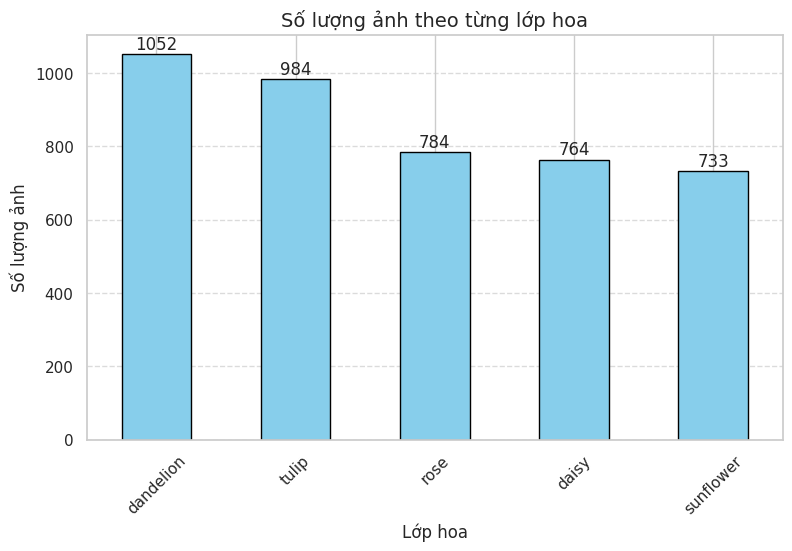

In [12]:
import matplotlib.pyplot as plt

class_counts = image_df['Label'].value_counts()


plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Số lượng ảnh theo từng lớp hoa', fontsize=14)
plt.xlabel('Lớp hoa', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(class_counts.values):
    plt.text(i, count + 2, str(count), ha='center', va='bottom')

plt.show()

## Split train/test/Valid

In [13]:
train_df, test_df = train_test_split(
    image_df,
    test_size=0.2,
    stratify=image_df["Label"],
    shuffle=True,
    random_state=42
)

## Build For MobileNetV3

In [14]:
# 4. ImageDataGenerator với MobileNetV3 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2,
    rotation_range=20,        # xoay ngẫu nhiên ±20 độ
    width_shift_range=0.1,    # dịch ngang
    height_shift_range=0.1,   # dịch dọc
    shear_range=0.1,          # biến dạng shear
    zoom_range=0.1,           # zoom ngẫu nhiên
    horizontal_flip=True      # lật ngang
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# 5. Tạo generator cho train / val / test
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=42
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

Found 2763 validated image filenames belonging to 5 classes.
Found 690 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


In [15]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])

## Load pretrained_model

In [16]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "bones_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)
]

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,309,445 (12.62 MB)

 Trainable params: 313,093 (1.19 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [20]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[
        callbacks,
        checkpoint_callback,
    ]
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.2647 - loss: 1.8202 - val_accuracy: 0.3362 - val_loss: 1.5418 - learning_rate: 1.0000e-05
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 952ms/step - accuracy: 0.3286 - loss: 1.5725 - val_accuracy: 0.4072 - val_loss: 1.4201 - learning_rate: 1.0000e-05
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 969ms/step - accuracy: 0.3820 - loss: 1.4619 - val_accuracy: 0.4609 - val_loss: 1.3195 - learning_rate: 1.0000e-05
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 936ms/step - accuracy: 0.4159 - loss: 1.3918 - val_accuracy: 0.5319 - val_loss: 1.2333 - learning_rate: 1.0000e-05
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 946ms/step - accuracy: 0.4508 - loss: 1.3032 - val_accuracy: 0.5812 - val_loss: 1.1632 - learning_rate: 1.0000e-05
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 933ms/step - accuracy: 0.5072 - loss: 1.2052 - val_accuracy: 0.6348 - val_loss: 1.1037 - learning_rate: 1.0000e-05
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 956ms/step - accura

14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
              precision    recall  f1-score   support

       daisy       0.79      0.84      0.82       153
   dandelion       0.85      0.89      0.87       210
        rose       0.80      0.83      0.82       157
   sunflower       0.84      0.74      0.79       147
       tulip       0.84      0.80      0.82       197

    accuracy                           0.83       864
   macro avg       0.83      0.82      0.82       864
weighted avg       0.83      0.83      0.83       864



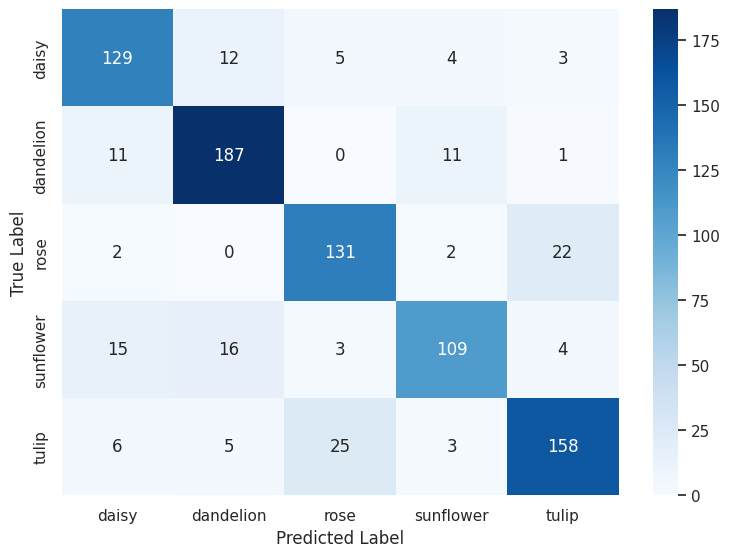

In [21]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.8338 - loss: 0.5336
✅ Test Accuracy: 0.8264
✅ Test Loss: 0.5489


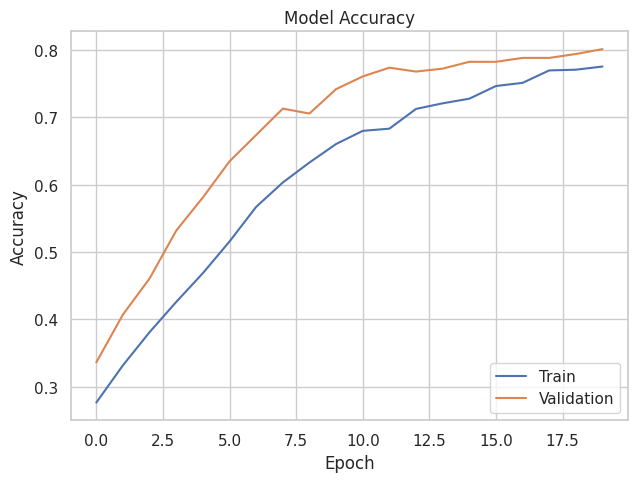

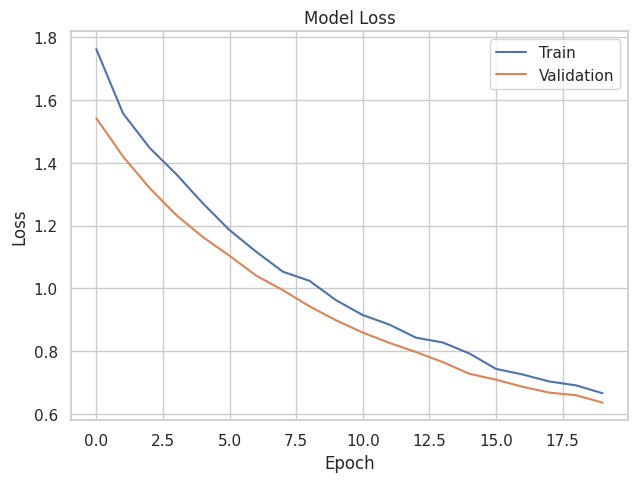

In [22]:
# Đánh giá trên test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# Accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


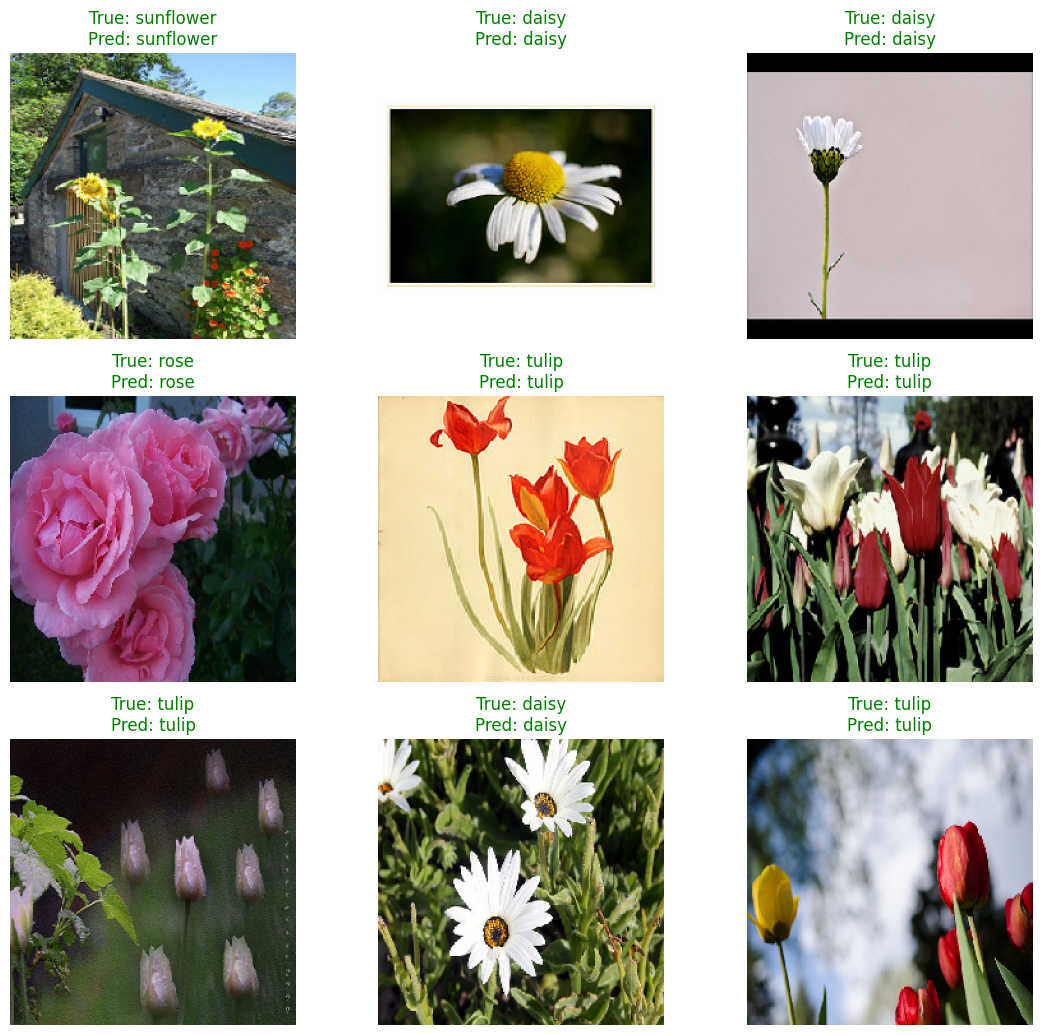

In [23]:
class_names = list(test_gen.class_indices.keys())
x_batch, y_batch = next(test_gen)

plt.figure(figsize=(12, 12))
for i in range(9):
    img = x_batch[i]
    true_label = class_names[np.argmax(y_batch[i])]
    pred_label = class_names[np.argmax(model.predict(img[np.newaxis, ...]))]

    plt.subplot(3, 3, i+1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=("green" if true_label==pred_label else "red"))
    plt.axis("off")
plt.show()

## Build For CNN-Keras

In [24]:
train_datagen_cnn = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen_cnn = ImageDataGenerator(rescale=1./255)

# --- 2. Generator ---
train_gen_cnn = train_datagen_cnn.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

val_gen_cnn = train_datagen_cnn.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=42
)

test_gen_cnn = test_datagen_cnn.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

Found 2763 validated image filenames belonging to 5 classes.
Found 690 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


In [25]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation='softmax')
])

In [26]:
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,957 (84.86 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
checkpoint_path_cnn = "flower_cnn_checkpoint.weights.h5"
checkpoint_callback_cnn = ModelCheckpoint(checkpoint_path_cnn,
                                          save_weights_only=True,
                                          monitor="val_accuracy",
                                          save_best_only=True)

callbacks_cnn = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)
]

In [28]:
history_cnn = cnn_model.fit(
    train_gen_cnn,
    validation_data=val_gen_cnn,
    epochs=20,
    callbacks=[checkpoint_callback_cnn] + callbacks_cnn
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2961 - loss: 1.5447 - val_accuracy: 0.4783 - val_loss: 1.2580 - learning_rate: 1.0000e-04
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4691 - loss: 1.2412 - val_accuracy: 0.5029 - val_loss: 1.1537 - learning_rate: 1.0000e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 957ms/step - accuracy: 0.5143 - loss: 1.1545 - val_accuracy: 0.5507 - val_loss: 1.0673 - learning_rate: 1.0000e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 979ms/step - accuracy: 0.5501 - loss: 1.0956 - val_accuracy: 0.6029 - val_loss: 1.0296 - learning_rate: 1.0000e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 959ms/step - accuracy: 0.5695 - loss: 1.0594 - val_accuracy: 0.6087 - val_loss: 1.0032 - learning_rate: 1.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 959ms/step - accuracy: 0.6157 - loss: 0.9887 - val_accuracy: 0.5971 - val_loss: 1.0258 - learning_rate: 1.0000e-04
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 937ms/step - accuracy:

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step
              precision    recall  f1-score   support

       daisy       0.68      0.67      0.68       153
   dandelion       0.74      0.70      0.72       210
        rose       0.63      0.52      0.57       157
   sunflower       0.62      0.86      0.72       147
       tulip       0.69      0.64      0.66       197

    accuracy                           0.67       864
   macro avg       0.67      0.68      0.67       864
weighted avg       0.68      0.67      0.67       864



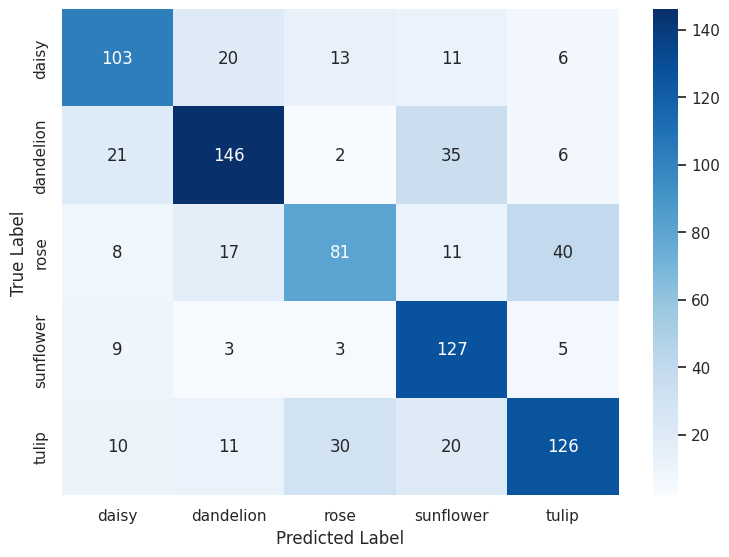

In [29]:
y_pred_cnn = cnn_model.predict(test_gen_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_cnn = test_gen_cnn.classes
class_labels_cnn = list(test_gen_cnn.class_indices.keys())

print(classification_report(y_true_cnn, y_pred_classes_cnn, target_names=class_labels_cnn))

cm_cnn = confusion_matrix(y_true_cnn, y_pred_classes_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels_cnn, yticklabels=class_labels_cnn)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [30]:
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_gen_cnn, verbose=1)
print(f"✅ Test Accuracy (CNN): {test_acc_cnn:.4f}")
print(f"✅ Test Loss (CNN): {test_loss_cnn:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.6836 - loss: 0.8335
✅ Test Accuracy (CNN): 0.6748
✅ Test Loss (CNN): 0.8587


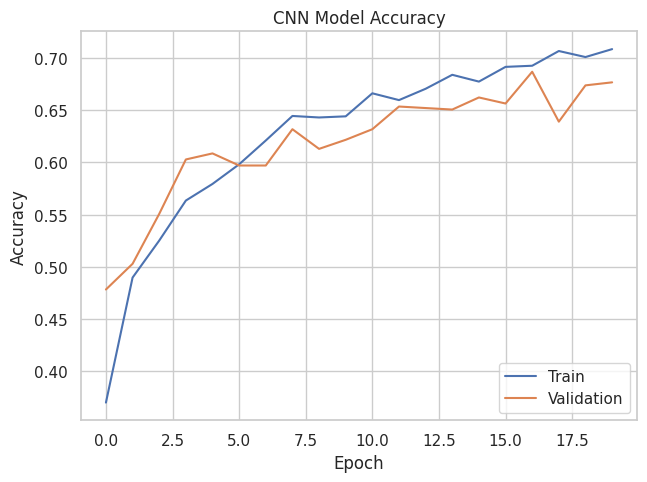

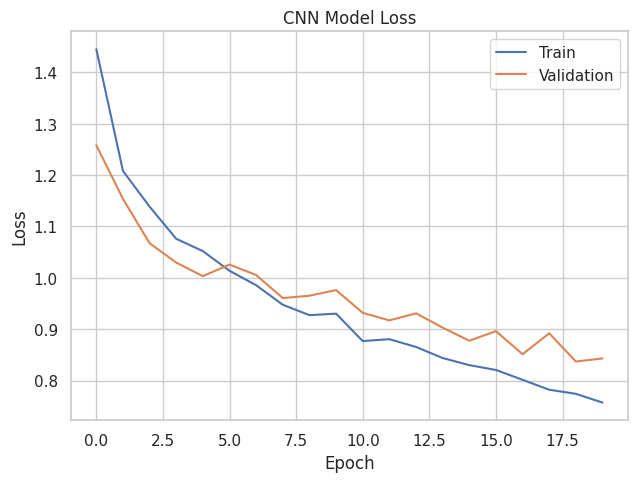

In [31]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


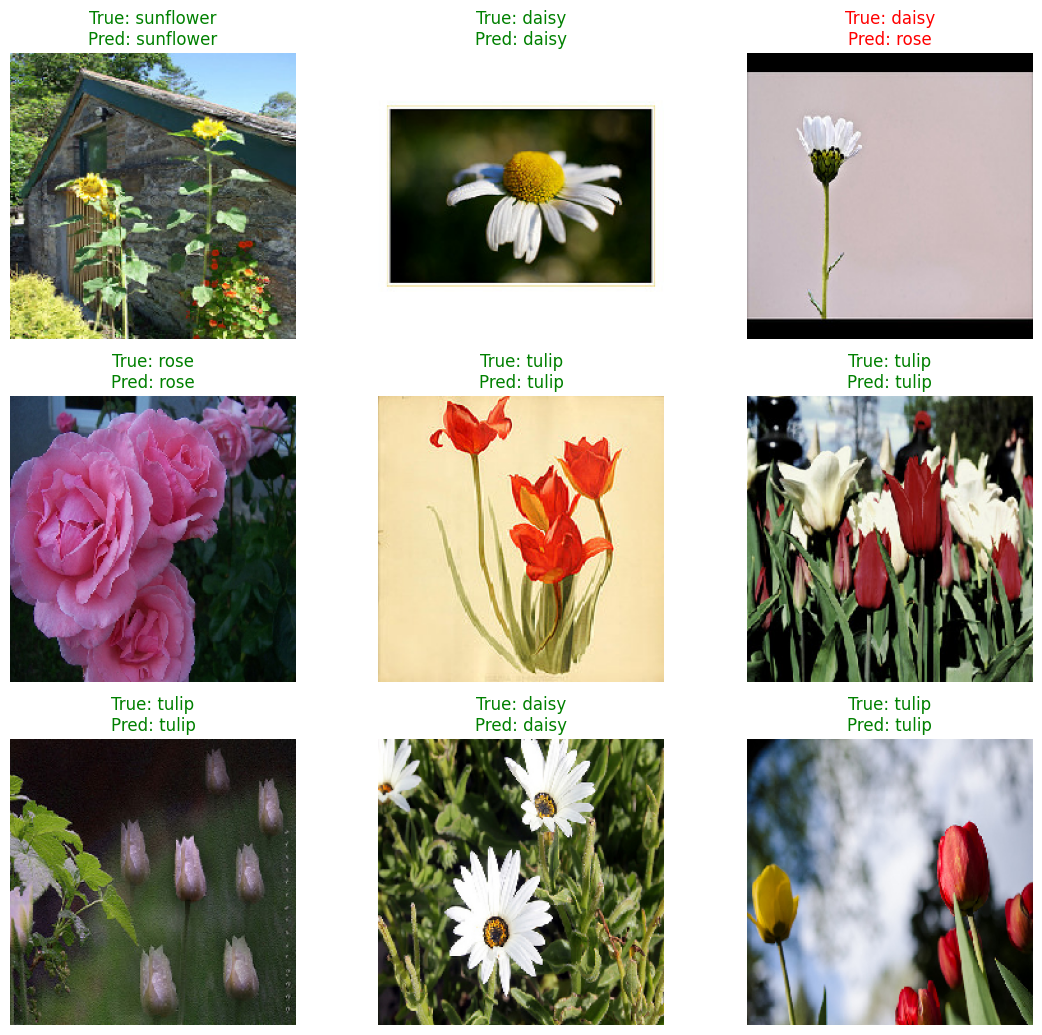

In [32]:
class_names_cnn = list(test_gen_cnn.class_indices.keys())
x_batch_cnn, y_batch_cnn = next(test_gen_cnn)

plt.figure(figsize=(12, 12))
for i in range(9):
    img = x_batch_cnn[i]
    true_label = class_names_cnn[np.argmax(y_batch_cnn[i])]
    pred_label = class_names_cnn[np.argmax(cnn_model.predict(img[np.newaxis, ...]))]

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color=("green" if true_label==pred_label else "red"))
    plt.axis("off")
plt.show()

## MobileNetV2

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1.Pretrained MobileNetV2
base_model_v2 = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model_v2.trainable = False  # freeze backbone

# 2. Callbacks
checkpoint_path_v2 = "bones_classification_mobilenetv2.weights.h5"
checkpoint_callback_v2 = ModelCheckpoint(
    checkpoint_path_v2,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

callbacks_v2 = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)
]

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
inputs_v2 = tf.keras.Input(shape=(224,224,3))

# Preprocess riêng của MobileNetV2
x_v2 = preprocess_input(inputs_v2)

# Backbone
x_v2 = base_model_v2(x_v2, training=False)

# Fully connected layers
x_v2 = Dense(256, activation='relu')(x_v2)
x_v2 = Dropout(0.2)(x_v2)
x_v2 = Dense(256, activation='relu')(x_v2)
x_v2 = Dropout(0.2)(x_v2)

# Output
outputs_v2 = Dense(len(classes), activation='softmax')(x_v2)

# Model MobileNetV2
model_v2 = Model(inputs=inputs_v2, outputs=outputs_v2)

# 4. Compile
model_v2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v2.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,652,997 (10.12 MB)

 Trainable params: 395,013 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [35]:
# 5. Train MobileNetV2
history_v2 = model_v2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint_callback_v2] + callbacks_v2
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.2268 - loss: 1.7975 - val_accuracy: 0.3116 - val_loss: 1.5692 - learning_rate: 1.0000e-05
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 955ms/step - accuracy: 0.3042 - loss: 1.5860 - val_accuracy: 0.4319 - val_loss: 1.4464 - learning_rate: 1.0000e-05
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 920ms/step - accuracy: 0.3648 - loss: 1.4677 - val_accuracy: 0.4884 - val_loss: 1.3512 - learning_rate: 1.0000e-05
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 945ms/step - accuracy: 0.4226 - loss: 1.3899 - val_accuracy: 0.5261 - val_loss: 1.2821 - learning_rate: 1.0000e-05
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 934ms/step - accuracy: 0.4960 - loss: 1.2887 - val_accuracy: 0.5841 - val_loss: 1.2008 - learning_rate: 1.0000e-05
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 971ms/step - accuracy: 0.5338 - loss: 1.2033 - val_accuracy: 0.6116 - val_loss: 1.1284 - learning_rate: 1.0000e-05
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 943ms/step - accura

In [36]:
# Evaluate trên test set
test_loss_v2, test_acc_v2 = model_v2.evaluate(test_gen, verbose=1)
print(f"✅ Test Accuracy (MobileNetV2): {test_acc_v2:.4f}")
print(f"✅ Test Loss (MobileNetV2): {test_loss_v2:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 912ms/step - accuracy: 0.8217 - loss: 0.5851
✅ Test Accuracy (MobileNetV2): 0.8206
✅ Test Loss (MobileNetV2): 0.5844


In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels trên test set
y_pred_v2 = model_v2.predict(test_gen)
y_pred_classes_v2 = np.argmax(y_pred_v2, axis=1)
y_true_v2 = test_gen.classes

# Classification report
print(classification_report(y_true_v2, y_pred_classes_v2, target_names=classes))

# Confusion matrix
cm_v2 = confusion_matrix(y_true_v2, y_pred_classes_v2)
print("Confusion Matrix:\n", cm_v2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step
              precision    recall  f1-score   support

       daisy       0.84      0.81      0.83       153
   dandelion       0.85      0.89      0.87       210
        rose       0.75      0.89      0.81       157
   sunflower       0.80      0.76      0.78       147
       tulip       0.86      0.75      0.80       197

    accuracy                           0.82       864
   macro avg       0.82      0.82      0.82       864
weighted avg       0.82      0.82      0.82       864

Confusion Matrix:
 [[124  14   5   7   3]
 [  6 186   2  11   5]
 [  1   1 140   2  13]
 [ 13  13   6 112   3]
 [  3   5  34   8 147]]


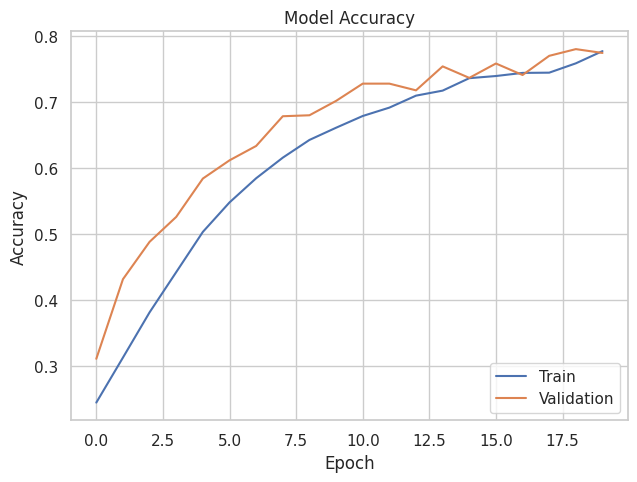

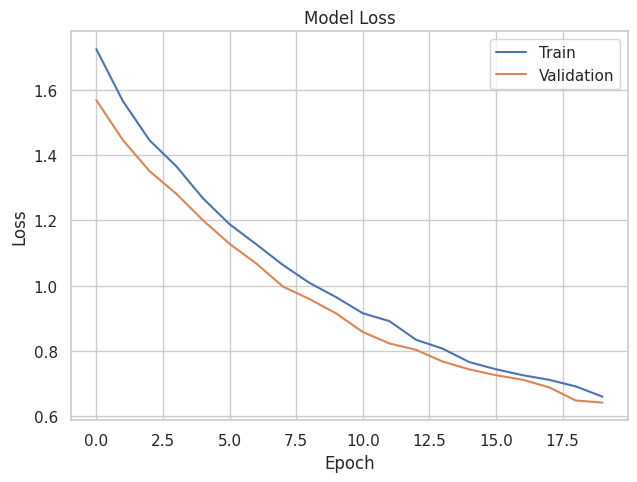

In [38]:
# Accuracy
plt.plot(model_v2.history.history['accuracy'])
plt.plot(model_v2.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Loss
plt.plot(model_v2.history.history['loss'])
plt.plot(model_v2.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## VGG19

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input

train_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Chuẩn hóa theo chuẩn VGG19
    validation_split=0.2,      # tách 20% dữ liệu validation
    rotation_range=20,         # xoay ngẫu nhiên ±20°
    width_shift_range=0.1,     # dịch ngang
    height_shift_range=0.1,    # dịch dọc
    shear_range=0.1,           # biến dạng shear
    zoom_range=0.1,            # zoom ngẫu nhiên
    horizontal_flip=True       # lật ngang ảnh
)

test_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input  # chỉ chuẩn hóa, không augment
)

train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_generator_vgg = test_datagen_vgg.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2763 validated image filenames belonging to 5 classes.
Found 690 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


In [40]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# --- Tải model VGG19 pretrained trên ImageNet ---
base_model_vgg = VGG19(
    weights='imagenet',
    include_top=False,        # bỏ phần fully connected gốc
    input_shape=(224, 224, 3)
)


for layer in base_model_vgg.layers:
    layer.trainable = False

x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)      # giảm chiều
x = Dense(256, activation='relu')(x) # fully connected
x = Dropout(0.5)(x)                  # giảm overfitting
predictions = Dense(len(train_generator_vgg.class_indices), activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
model_vgg.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_vgg.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,156,997 (76.89 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [42]:
history_vgg = model_vgg.fit(
    train_generator_vgg,
    validation_data=val_generator_vgg,
    epochs=20,
    verbose=1
)

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 725ms/step - accuracy: 0.2612 - loss: 6.1016 - val_accuracy: 0.5971 - val_loss: 1.4159
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 548ms/step - accuracy: 0.4858 - loss: 2.5465 - val_accuracy: 0.7174 - val_loss: 0.9661
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 556ms/step - accuracy: 0.5966 - loss: 1.7597 - val_accuracy: 0.7493 - val_loss: 0.8282
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 543ms/step - accuracy: 0.6542 - loss: 1.3851 - val_accuracy: 0.7754 - val_loss: 0.7245
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 544ms/step - accuracy: 0.6701 - loss: 1.2361 - val_accuracy: 0.7986 - val_loss: 0.6489
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 546ms/step - accuracy: 0.7222 - loss: 1.0044 - val_accuracy: 0.8058 - val_loss: 0.6482
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 49s 567ms/step - accuracy: 0.7360 - loss: 0.8839 - val_accuracy: 0.8101 - val_loss: 0.6109
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 49s 561ms/step - accuracy: 0.7424 - loss: 0.8010 - val_accu

In [43]:
test_loss, test_acc = model_vgg.evaluate(test_generator_vgg)
print(f'Test accuracy: {test_acc:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.8765 - loss: 0.3606
Test accuracy: 0.8727


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# --- Predict labels trên test set ---
y_pred_vgg = model_vgg.predict(test_generator_vgg)
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)
y_true_vgg = test_generator_vgg.classes

# --- Lấy tên lớp ---
class_labels_vgg = list(test_generator_vgg.class_indices.keys())

# --- Classification report ---
print(classification_report(y_true_vgg, y_pred_classes_vgg, target_names=class_labels_vgg))

# --- Confusion matrix ---
cm_vgg = confusion_matrix(y_true_vgg, y_pred_classes_vgg)
print("Confusion Matrix:\n", cm_vgg)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step
              precision    recall  f1-score   support

       daisy       0.87      0.89      0.88       153
   dandelion       0.94      0.90      0.92       210
        rose       0.80      0.90      0.84       157
   sunflower       0.86      0.91      0.88       147
       tulip       0.89      0.78      0.83       197

    accuracy                           0.87       864
   macro avg       0.87      0.88      0.87       864
weighted avg       0.88      0.87      0.87       864

Confusion Matrix:
 [[136   6   4   5   2]
 [  6 189   4   6   5]
 [  2   0 141   2  12]
 [  6   6   1 134   0]
 [  6   1  27   9 154]]


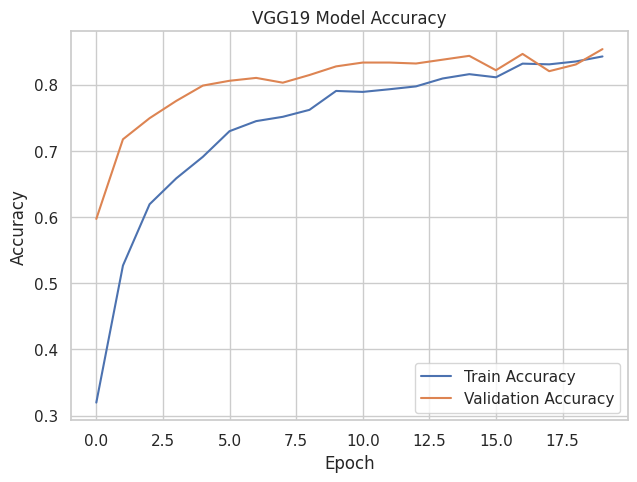

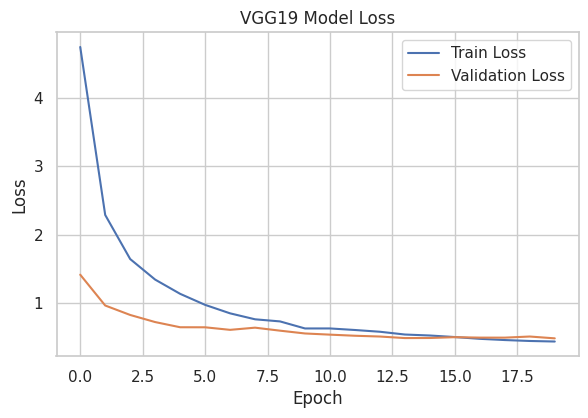

In [45]:
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('VGG19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Compare the Accuracy and Loss among these models

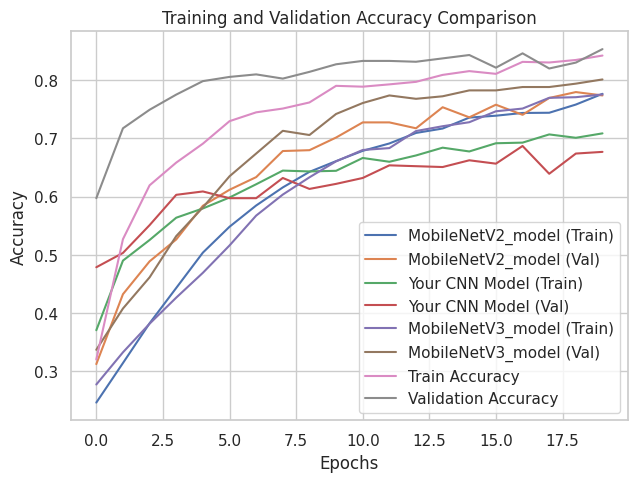

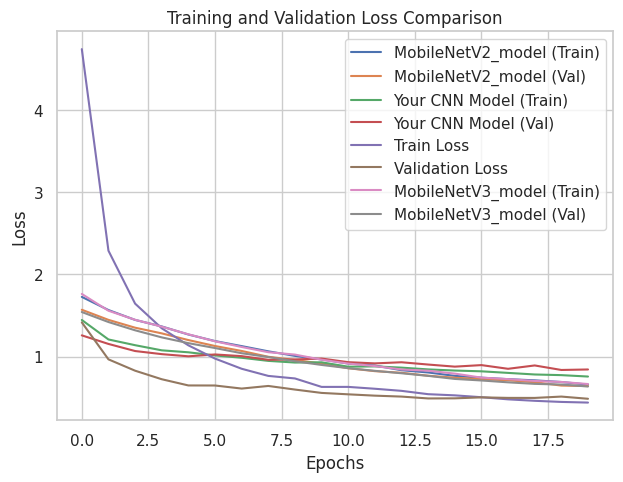

In [47]:
plt.plot(model_v2.history.history['accuracy'], label='MobileNetV2_model (Train)')
plt.plot(model_v2.history.history['val_accuracy'], label='MobileNetV2_model (Val)')
plt.plot(history_cnn.history['accuracy'], label='Your CNN Model (Train)')
plt.plot(history_cnn.history['val_accuracy'], label='Your CNN Model (Val)')
plt.plot(history.history['accuracy'], label='MobileNetV3_model (Train)')
plt.plot(history.history['val_accuracy'], label='MobileNetV3_model (Val)')
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()

plt.plot(model_v2.history.history['loss'], label='MobileNetV2_model (Train)')
plt.plot(model_v2.history.history['val_loss'], label='MobileNetV2_model (Val)')
plt.plot(history_cnn.history['loss'], label='Your CNN Model (Train)') # Changed history to history_cnn
plt.plot(history_cnn.history['val_loss'], label='Your CNN Model (Val)') # Changed history to history_cnn
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='MobileNetV3_model (Train)')
plt.plot(history.history['val_loss'], label='MobileNetV3_model (Val)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

In [49]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 137.0 MB/s eta 0:00:00


## Save model

In [51]:
model.save("Flower_model.h5")

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large

# Define the custom layer (needs to be defined in the same script/notebook)
class ResizeAndRescale(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), **kwargs):
        super().__init__(**kwargs)
        self.img_size = img_size
        self.resizing = layers.Resizing(img_size[0], img_size[1])
        self.rescaling = layers.Rescaling(1./255)

    def call(self, images):
        x = self.resizing(images)
        x = self.rescaling(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "img_size": self.img_size,
        })
        return config

# Recreate the base model
pretrained_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# Recreate the model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = ResizeAndRescale(img_size=(224, 224))(inputs) # Use the custom layer here

# Assuming the rest of the model is attached after the base model's output directly
# If there were other layers before the dense layers, they would need to be added here as well.
# Based on the original model summary, it seems the dense layers are added after the base model's output.
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# Assuming the output layer is directly connected after the dropout layers
# The number of classes is 5 based on previous cells
outputs = Dense(5, activation='softmax')(x)


model = Model(inputs=pretrained_model.input, outputs=outputs)

# Load the weights from the saved file
model.load_weights("Flower_model.h5")

# Compile the model (necessary before making predictions)
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,309,445 (12.62 MB)

 Trainable params: 313,093 (1.19 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [59]:
import streamlit as st
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_preprocess_input
from tensorflow.keras import layers
import tensorflow as tf

# Define the custom layer (must be defined in the same script for Streamlit)
class ResizeAndRescale(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), **kwargs):
        super().__init__(**kwargs)
        self.img_size = img_size
        self.resizing = layers.Resizing(img_size[0], img_size[1])
        self.rescaling = layers.Rescaling(1./255)

    def call(self, images):
        x = self.resizing(images)
        x = self.rescaling(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "img_size": self.img_size,
        })
        return config

# Recreate the base model and load weights (as done in the previous successful cell)
from tensorflow.keras.applications import MobileNetV3Large

pretrained_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = ResizeAndRescale(img_size=(224, 224))(inputs)

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=pretrained_model.input, outputs=outputs)

# Load the weights from the saved file
try:
    model.load_weights("Flower_model.h5")
except Exception as e:
    st.error(f"Error loading model weights: {e}")
    st.stop()


class_labels = ["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"]

def detect_flower(image_file, img_size=(224, 224)):
    img = Image.open(image_file).convert("RGB")
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    output = img.copy()

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (20, 40, 40), (179, 255, 255))

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h < 500:
            continue

        roi = img[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, img_size)
        roi_array = img_to_array(roi_resized)
        roi_array = np.expand_dims(roi_array, axis=0)
        preprocessed_roi = mobilenetv3_preprocess_input(roi_array)

        preds = model.predict(preprocessed_roi)
        class_idx = np.argmax(preds, axis=1)[0]
        label = class_labels[class_idx]
        confidence = np.max(preds)

        cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(output, f"{label} {confidence:.2f}", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    return output

In [60]:
st.title("Flower Detection App")

uploaded_file = st.file_uploader("Upload an image : ", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image.", use_column_width=True)

    # Detect flowers
    result_image = detect_flower(uploaded_file)

    st.image(result_image, caption="Detected Flowers.", use_column_width=True)

2025-10-28 05:09:04.327 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 05:09:04.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 05:09:04.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 05:09:04.347 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 05:09:04.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 05:09:04.355 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 05:09:04.361 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 05:09:04.366 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Save in Drive

In [61]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful